**Soft Computing Project : Smile Detection Using CelebFaces Dataset**

# Dataset description

**CelebFaces Attributes Dataset (CelebA)** is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter. CelebA has large diversities, large quantities, and rich annotations, including
- 10,177 number of identities,

- 202,599 number of face images, and

- 5 landmark locations, 40 binary attributes annotations per image.

The dataset can be employed as the training and test sets for the following computer vision tasks: face attribute recognition, face detection, landmark (or facial part) localization, and face editing & synthesis.
- Image size : 178*218 


# Model Descriptions

|Model|Learning rate | Losss function | Optimizer |Batch| Epochs|Iteration |Hidden layer activation|Neuron Count| 
|:-----------:|:-----------:|:--------------:|:---------:|:------:|:------:|:------:|:------:|:--------:|
|Model 1|       0.005  |Cross-Entropy| Adam |100|1|1216|Tanh, ReLU|500, 100|
|Model 2|       0.005  |Cross-Entropy| Adam |100|2|2432|ReLU, ReLU|500, 100|
|Model 3|       0.1  |Cross-Entropy| SGD |100|1|1216|ReLU, ReLU|500, 100|
|Model 4|       0.001  |Cross-Entropy| Adam |100|2|2432|ReLU, LeakyReLU, LeakyReLU|500, 100,100|

# Loading Dataset

In [ ]:
import os
from os import path
import shutil
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
from sklearn.preprocessing import StandardScaler
import random
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
!nvidia-smi

Mon Mar 29 03:21:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
print(torch.__version__)
print(torch.cuda.get_device_name())


1.8.0+cu101
Tesla P100-PCIE-16GB


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
a = pd.read_csv ('/content/drive/MyDrive/list_attr_celeba.txt', sep="\s+")




In [ ]:
m=np.array(a)
k=0
for j in a.columns:
  count=0
  for i in range(len(m)):
    if m[i][k]==1:
      count=count+1
  if(str(j)=='filename'):
    print('Attribute'+'---------------------'+'positive samples'+ '-------------------'+'negative samples')
  else:
    print(str(j)+'---------------------------'+str(count)+ '-----------------------------'+str(202599-count))
  k=k+1

Attribute---------------------positive samples-------------------negative samples
5_o_Clock_Shadow---------------------------22516-----------------------------180083
Arched_Eyebrows---------------------------54090-----------------------------148509
Attractive---------------------------103833-----------------------------98766
Bags_Under_Eyes---------------------------41446-----------------------------161153
Bald---------------------------4547-----------------------------198052
Bangs---------------------------30709-----------------------------171890
Big_Lips---------------------------48785-----------------------------153814
Big_Nose---------------------------47516-----------------------------155083
Black_Hair---------------------------48472-----------------------------154127
Blond_Hair---------------------------29983-----------------------------172616
Blurry---------------------------10312-----------------------------192287
Brown_Hair---------------------------41572----------------------

In [ ]:
print(a)

          filename  5_o_Clock_Shadow  ...  Wearing_Necktie  Young
0       000001.jpg                -1  ...               -1      1
1       000002.jpg                -1  ...               -1      1
2       000003.jpg                -1  ...               -1      1
3       000004.jpg                -1  ...               -1      1
4       000005.jpg                -1  ...               -1      1
...            ...               ...  ...              ...    ...
202594  202595.jpg                -1  ...               -1      1
202595  202596.jpg                -1  ...               -1      1
202596  202597.jpg                -1  ...               -1      1
202597  202598.jpg                -1  ...               -1      1
202598  202599.jpg                -1  ...               -1      1

[202599 rows x 41 columns]


In [ ]:
def dropColumns(csv_file):
  csv_file = csv_file[['filename', 'Smiling']]
  print(csv_file)
  print(csv_file.iloc[:5, :])   #First 5 Rows of the CSV File
  print("=============================")
  return csv_file

In [ ]:
a=dropColumns(a)
a=np.array(a)


          filename  Smiling
0       000001.jpg        1
1       000002.jpg        1
2       000003.jpg       -1
3       000004.jpg       -1
4       000005.jpg       -1
...            ...      ...
202594  202595.jpg       -1
202595  202596.jpg        1
202596  202597.jpg        1
202597  202598.jpg        1
202598  202599.jpg       -1

[202599 rows x 2 columns]
     filename  Smiling
0  000001.jpg        1
1  000002.jpg        1
2  000003.jpg       -1
3  000004.jpg       -1
4  000005.jpg       -1


In [ ]:
train=[]

for i in range(len(a)):
  temp=[]
  temp.append(a[i][0])
  if a[i][1]==-1 :
    temp.append(0)
  else :
    temp.append(a[i][1])
  train.append(temp)
train=pd.DataFrame(train)
train

,0,1
0,000001.jpg,1
1,000002.jpg,1
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0
...,...,...
202594,202595.jpg,0
202595,202596.jpg,1
202596,202597.jpg,1
202597,202598.jpg,1


In [ ]:
!unzip '/content/drive/MyDrive/img_align_celeba.zip'

Streaming output truncated to the last 5000 lines.
 extracting: img_align_celeba/197600.jpg  
 extracting: img_align_celeba/197601.jpg  
 extracting: img_align_celeba/197602.jpg  
 extracting: img_align_celeba/197603.jpg  
 extracting: img_align_celeba/197604.jpg  
 extracting: img_align_celeba/197605.jpg  
 extracting: img_align_celeba/197606.jpg  
 extracting: img_align_celeba/197607.jpg  
 extracting: img_align_celeba/197608.jpg  
 extracting: img_align_celeba/197609.jpg  
 extracting: img_align_celeba/197610.jpg  
 extracting: img_align_celeba/197611.jpg  
 extracting: img_align_celeba/197612.jpg  
 extracting: img_align_celeba/197613.jpg  
 extracting: img_align_celeba/197614.jpg  
 extracting: img_align_celeba/197615.jpg  
 extracting: img_align_celeba/197616.jpg  
 extracting: img_align_celeba/197617.jpg  
 extracting: img_align_celeba/197618.jpg  
 extracting: img_align_celeba/197619.jpg  
 extracting: img_align_celeba/197620.jpg  
 extracting: img_align_celeba/197621.jpg  
 ex

In [ ]:
TRAIN_PATH = '/content/img_align_celeba'


In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
mean = [0.5,]                                             # Resize and normalization
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(40),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(40),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

val_transform = transforms.Compose([
        transforms.Resize(40),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(train, TRAIN_PATH, train_transform)
test_data  = Dataset(train, TRAIN_PATH, test_transform)
val_data  = Dataset(train, TRAIN_PATH, val_transform)


print("Total Samples: ",len(train_data))
len(train_data[0])


Total Samples:  202599


2

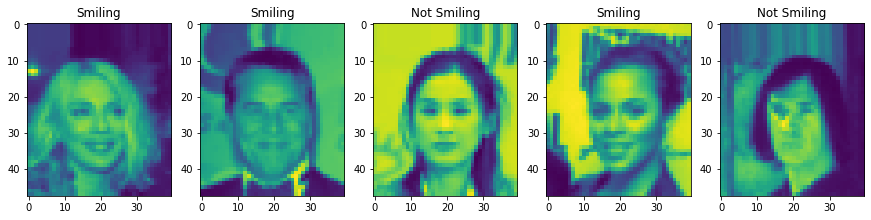

In [ ]:
## Displaying some CelebFaces Images

import matplotlib.pyplot as plt 
import numpy as np
fig,ax=plt.subplots(1,5,figsize=(15,15))

for i in range(5):
  a=random.randint(1,202599)
  show_img = train_data[a][0].numpy().reshape(48,40)

  ax[i].imshow(show_img)

  if train_data[a][1]==1:
    ax[i].set_title('Smiling')
  else:
    ax[i].set_title('Not Smiling')



# Model 1

In [ ]:
batch_size = 100
num_iters = 1216
learning_rate = 0.005
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#splitting the training set to 60%, validation set to 20% and test set to 20%.

test_size = 0.2

num_train = len(train_data)

indices = list(range(num_train))

np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))         

train_idx, test_idx = indices[split:], indices[:split]  




val_size = 0.25

num2 = len(train_idx)

indices = list(range(num2))

np.random.shuffle(indices)
split = int(np.floor(val_size * num2))  
train_idx, val_idx = indices[split:], indices[:split] 




train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
val_sampler = SubsetRandomSampler(val_idx)


train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

val_loader = torch.utils.data.DataLoader(
    val_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train samples: ",len(train_sampler))
print("Test samples: ",len(test_sampler))
print("Validation samples: ",len(val_sampler))


Train samples:  121560
Test samples:  40519
Validation samples:  40520


In [ ]:

num_epochs = num_iters / (len(train_sampler) / batch_size)
num_epochs = int(num_epochs)
num_epochs

1

In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        ### 1st hidden layer: 1920 --> 500
        self.linear_1 = nn.Linear(input_size, 500)
        ### Non-linearity in 1st hidden layer
        self.layer_1 = nn.Tanh()

        ### 2nd hidden layer: 500 --> 100
        self.linear_2 = nn.Linear(500,100)
        ### Non-linearity in 2nd hidden layer
        self.layer_2 = nn.ReLU()

        



        ### Output layer: 100 --> 2
        self.linear_out = nn.Linear(100, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.layer_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.layer_2(out)

        

    
        
        # Linear layer (output)
        logits  = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = DeepNeuralNetworkModel(input_size = 48*40,
                           num_classes = 2)
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=1920, out_features=500, bias=True)
  (layer_1): Tanh()
  (linear_2): Linear(in_features=500, out_features=100, bias=True)
  (layer_2): ReLU()
  (linear_out): Linear(in_features=100, out_features=2, bias=True)
)

In [ ]:

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
accuracy_gain = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 48*40).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 10 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in val_loader:
               
                images = images.view(-1, 48*40).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            accuracy_gain.append(accuracy)
            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 10. Loss: 0.7796106934547424. Accuracy: 53.8340038006861
Iteration: 20. Loss: 0.6545742154121399. Accuracy: 58.157901231521016
Iteration: 30. Loss: 0.6777450442314148. Accuracy: 62.558305979910656
Iteration: 40. Loss: 0.6213401556015015. Accuracy: 69.2934179027123
Iteration: 50. Loss: 0.4886918365955353. Accuracy: 74.12571879858832
Iteration: 60. Loss: 0.46643558144569397. Accuracy: 75.3868555492485
Iteration: 70. Loss: 0.4164316952228546. Accuracy: 79.15545793331523
Iteration: 80. Loss: 0.4107271134853363. Accuracy: 75.70028875342432
Iteration: 90. Loss: 0.4997573792934418. Accuracy: 76.31975122781905
Iteration: 100. Loss: 0.4285595417022705. Accuracy: 80.39191490411906
Iteration: 110. Loss: 0.4303124248981476. Accuracy: 82.79819344011452
Iteration: 120. Loss: 0.3939400911331177. Accuracy: 81.76164268614724
Iteration: 130. Loss: 0.47405803203582764. Accuracy: 80.57454527505615
Iteration: 140. Loss: 0.382712721824646. Accuracy: 79.14065006540142
Iteration: 150. Loss: 0.33139

[0.7796106934547424, 0.6545742154121399, 0.6777450442314148, 0.6213401556015015, 0.4886918365955353, 0.46643558144569397, 0.4164316952228546, 0.4107271134853363, 0.4997573792934418, 0.4285595417022705, 0.4303124248981476, 0.3939400911331177, 0.47405803203582764, 0.382712721824646, 0.3313921391963959, 0.4089493155479431, 0.32095229625701904, 0.3843212127685547, 0.45825985074043274, 0.3765734136104584, 0.385675311088562, 0.40333330631256104, 0.3580095171928406, 0.43199092149734497, 0.4687095880508423, 0.4833242893218994, 0.4424344301223755, 0.31748515367507935, 0.4208238124847412, 0.34255707263946533, 0.39609163999557495, 0.3582333028316498, 0.3127974271774292, 0.33583614230155945, 0.3150605261325836, 0.3871055841445923, 0.43368539214134216, 0.2521093487739563, 0.42988231778144836, 0.32013630867004395, 0.3928831219673157, 0.35650432109832764, 0.3511863052845001, 0.346445232629776, 0.2948244512081146, 0.35536184906959534, 0.379688024520874, 0.20220625400543213, 0.28074872493743896, 0.4624

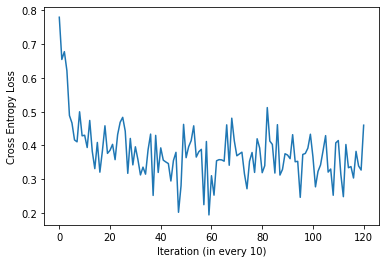

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 10)')
plt.show()

[53.8340038006861, 58.157901231521016, 62.558305979910656, 69.2934179027123, 74.12571879858832, 75.3868555492485, 79.15545793331523, 75.70028875342432, 76.31975122781905, 80.39191490411906, 82.79819344011452, 81.76164268614724, 80.57454527505615, 79.14065006540142, 82.6550507169476, 80.66832843851033, 82.37863718255633, 84.20000493595597, 83.58547841753251, 79.11103432957378, 77.8227498210716, 81.1890717934796, 82.06273600039488, 80.98916557664306, 82.9734198770947, 84.50109825020361, 84.11362570645869, 81.27298304499124, 83.32140477306942, 84.43446284459142, 83.33127668501197, 84.79725560847997, 84.01984254300451, 83.80266048026851, 83.89397566573706, 84.57760556775834, 84.82440336632197, 84.57020163380143, 80.9990374885856, 84.55786174387325, 84.4393988005627, 84.91078259581924, 85.55739282805597, 84.69853648905452, 84.54058589797378, 84.01984254300451, 84.55045780991634, 84.70594042301143, 83.40038006860979, 85.06132925294307, 84.30859596732397, 84.72568424689652, 85.08107307682816,

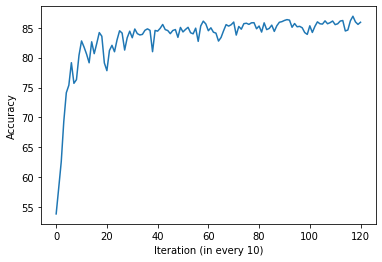

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (accuracy_gain)
plt.plot(accuracy_gain)
plt.ylabel('Accuracy')
plt.xlabel('Iteration (in every 10)')
plt.show()

### Save Model

In [ ]:
save_model = True
root_path='/content/drive/MyDrive/savedmodels/'
if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), root_path + 'sc1.pkl') 

### Load Model

In [ ]:
load_model = True
root_path='/content/drive/MyDrive/savedmodels/'
if load_model is True:
    model.load_state_dict(torch.load(root_path + 'sc1.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


### Testing Loaded Model with Digits

In [ ]:
def F_score(logit, label, threshold=0.5):
    prob = torch.sigmoid(logit)
    prob = prob > threshold
    label = label > threshold
    TP = (prob & label).sum().float()
    TN = ((~prob) & (~label)).sum().float()
    FP = (prob & (~label)).sum().float()
    FN = ((~prob) & label).sum().float()
    return TP,TN,FP,FN

In [ ]:
TP=0
TN=0
FP=0
FN=0

for images, labels in test_loader:
               
                images = images.view(-1, 48*40).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)
                
                T_P,T_N,F_P,F_N = F_score(predicted.cpu().squeeze(), labels.cpu().float())
                T_P=T_P.cpu().numpy()
                T_N=T_N.cpu().numpy()
                F_P=F_P.cpu().numpy()
                F_N=F_N.cpu().numpy()
                TP+=T_P
                TN+=T_N
                FP+=F_P
                FN+=F_N


In [ ]:
TN, TP, FN, FP, TP+TN+FP+FN

(18609.0, 16075.0, 3485.0, 2350.0, 40519.0)

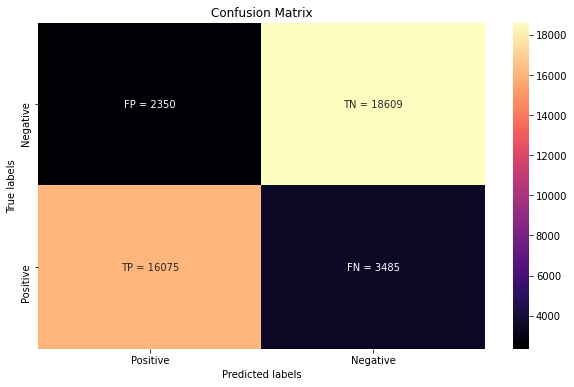

In [ ]:


import seaborn as sns
import matplotlib.pyplot as plt   
labels= [['FP = '+str(int(FP)),'TN = '+str(int(TN))],['TP = '+str(int(TP)),'FN = '+str(int(FN))]] 
values = [[FP,TN],[TP,FN]]
values=[[int(i) for i in x] for x in values]

plt.figure(figsize=(10,6))

ax= plt.subplot()

sns.heatmap(values, annot=labels, ax = ax,fmt='',cmap="magma"); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Positive','Negative']); ax.yaxis.set_ticklabels(['Negative','Positive']);

In [ ]:
accuracy = ((TP+TN)/(TP+TN+FP+FN))*100
precision = (TP / (TP + FP ))*100
recall = (TP / (TP + FN ))*100
F1 = (2 * precision * recall / ( precision + recall ))

accuracy,precision,recall,F1

(85.5993484538118, 87.24559023066486, 82.18302658486708, 84.63867316045807)

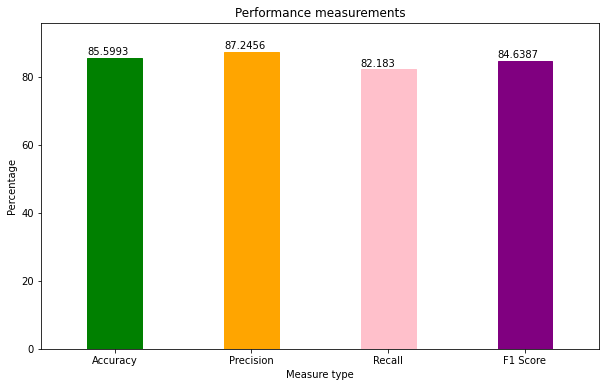

In [ ]:
data = {'Accuracy':accuracy, 'Precision':precision, 'Recall':recall,
        'F1 Score':F1}
figlabel = list(data.keys())
figvalues = list(data.values())
  
fig = plt.figure(figsize = (10, 6))
 
# creating the bar plot
barlist=plt.bar(figlabel, figvalues,width = 0.4)
barlist[0].set_color('green')
barlist[1].set_color('orange')
barlist[2].set_color('pink')
barlist[3].set_color('purple')
for bar in (barlist):
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + 1, round(yval,4))
plt.xlabel("Measure type")
plt.ylabel("Percentage")
plt.title("Performance measurements")
plt.margins(0.1)
plt.show()

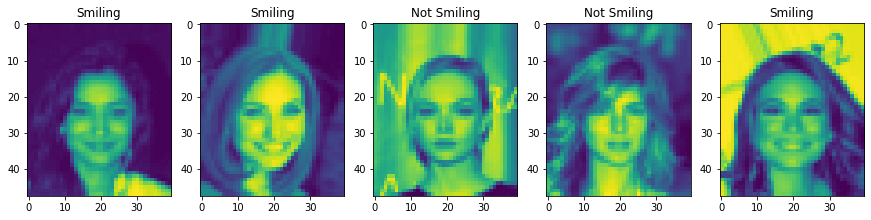

In [ ]:
for images, labels in test_loader:
    break
    
fig, ax = plt.subplots(1, 5,figsize=(15,15))
for i in range(5):
    ax[i].imshow(images[i].view(48, 40))
    if labels[i]==1:
      ax[i].set_title('Smiling')
    else:
      ax[i].set_title('Not Smiling')

plt.show()


  



In [ ]:
_, predictions = model.forward(images[:5].view(-1, 48*40).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels : ')
for i in range(5):
  if predictions[i].cpu().numpy()==1:
    print('Picture '+str(i)+' : Smiling')
  else:
    print('Picture '+str(i)+' : Not Smiling')

Predicted labels : 
Picture 0 : Smiling
Picture 1 : Smiling
Picture 2 : Not Smiling
Picture 3 : Not Smiling
Picture 4 : Smiling


# Model 2

In [ ]:
batch_size = 100
num_iters = 2432
learning_rate = 0.005
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#splitting the training set to 60%, validation set to 20% and test set to 20%.

test_size = 0.2

num_train = len(train_data)

indices = list(range(num_train))

np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))        

train_idx, test_idx = indices[split:], indices[:split]  




val_size = 0.25

num2 = len(train_idx)

indices = list(range(num2))

np.random.shuffle(indices)
split = int(np.floor(val_size * num2))  
train_idx, val_idx = indices[split:], indices[:split] 




train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
val_sampler = SubsetRandomSampler(val_idx)


train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

val_loader = torch.utils.data.DataLoader(
    val_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train samples: ",len(train_sampler))
print("Test samples: ",len(test_sampler))
print("Validation samples: ",len(val_sampler))


Train samples:  121560
Test samples:  40519
Validation samples:  40520


In [ ]:

num_epochs = num_iters / (len(train_sampler) / batch_size)
num_epochs = int(num_epochs)
num_epochs

2

In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        ### 1st hidden layer: 1920 --> 500
        self.linear_1 = nn.Linear(input_size, 500)
        ### Non-linearity in 1st hidden layer
        self.layer_1 = nn.ReLU()

        ### 2nd hidden layer: 500 --> 100
        self.linear_2 = nn.Linear(500,100)
        ### Non-linearity in 2nd hidden layer
        self.layer_2 = nn.ReLU()

        



        ### Output layer: 100 --> 2
        self.linear_out = nn.Linear(100, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.layer_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.layer_2(out)

        

    
        
        # Linear layer (output)
        logits  = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = DeepNeuralNetworkModel(input_size = 48*40,
                           num_classes = 2)
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=1920, out_features=500, bias=True)
  (layer_1): ReLU()
  (linear_2): Linear(in_features=500, out_features=100, bias=True)
  (layer_2): ReLU()
  (linear_out): Linear(in_features=100, out_features=2, bias=True)
)

In [ ]:

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
accuracy_gain = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 48*40).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 10 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in val_loader:
               
                images = images.view(-1, 48*40).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            accuracy_gain.append(accuracy)
            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 10. Loss: 0.6966007947921753. Accuracy: 50.59601668353118
Iteration: 20. Loss: 0.6859152913093567. Accuracy: 53.5625262222661
Iteration: 30. Loss: 0.6411924958229065. Accuracy: 60.67030282089884
Iteration: 40. Loss: 0.6645856499671936. Accuracy: 65.2015104025272
Iteration: 50. Loss: 0.6293084025382996. Accuracy: 71.90947456748685
Iteration: 60. Loss: 0.5522929430007935. Accuracy: 76.65539623386559
Iteration: 70. Loss: 0.5084055066108704. Accuracy: 80.92746612700215
Iteration: 80. Loss: 0.3765275180339813. Accuracy: 78.50884770107851
Iteration: 90. Loss: 0.46672093868255615. Accuracy: 81.47042128384214
Iteration: 100. Loss: 0.4272671043872833. Accuracy: 83.62990202127396
Iteration: 110. Loss: 0.4215487539768219. Accuracy: 78.37557688985414
Iteration: 120. Loss: 0.40477126836776733. Accuracy: 84.37523137293616
Iteration: 130. Loss: 0.23609808087348938. Accuracy: 84.50356622818924
Iteration: 140. Loss: 0.5101463794708252. Accuracy: 84.2691083195538
Iteration: 150. Loss: 0.43811

[0.6966007947921753, 0.6859152913093567, 0.6411924958229065, 0.6645856499671936, 0.6293084025382996, 0.5522929430007935, 0.5084055066108704, 0.3765275180339813, 0.46672093868255615, 0.4272671043872833, 0.4215487539768219, 0.40477126836776733, 0.23609808087348938, 0.5101463794708252, 0.4381117522716522, 0.35314300656318665, 0.3593366742134094, 0.2739737331867218, 0.3826228082180023, 0.26567646861076355, 0.36436042189598083, 0.2623481750488281, 0.25490662455558777, 0.2954140603542328, 0.3179047405719757, 0.2671302855014801, 0.333221971988678, 0.29461851716041565, 0.2632153630256653, 0.38534873723983765, 0.36991986632347107, 0.27006950974464417, 0.29558801651000977, 0.2831214964389801, 0.32274678349494934, 0.3435942530632019, 0.218749538064003, 0.3112945556640625, 0.33541885018348694, 0.28203827142715454, 0.31355488300323486, 0.3565390110015869, 0.2387426197528839, 0.2458425909280777, 0.31116557121276855, 0.27573445439338684, 0.2858158349990845, 0.25032839179039, 0.3493598997592926, 0.241

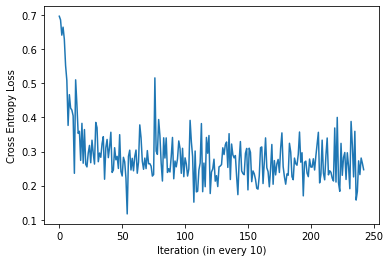

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 10)')
plt.show()

[50.59601668353118, 53.5625262222661, 60.67030282089884, 65.2015104025272, 71.90947456748685, 76.65539623386559, 80.92746612700215, 78.50884770107851, 81.47042128384214, 83.62990202127396, 78.37557688985414, 84.37523137293616, 84.50356622818924, 84.2691083195538, 82.65011476097634, 85.10328487869889, 85.53271304819961, 85.74742713294998, 86.27063846590488, 83.11162664429034, 84.7380241368247, 86.42365310101434, 86.93205656605544, 86.64577111972162, 85.9251215479158, 86.86295318245762, 86.38910140921543, 86.01150077741306, 87.44786396505343, 86.46067277079888, 87.77610503714307, 87.51203139267997, 86.9172486981416, 85.82393445050471, 86.23361879612034, 87.15911054073398, 87.09741109109306, 85.91524963597325, 87.11221895900688, 86.91231274217034, 86.86542116044325, 88.38569559959525, 87.4453959870678, 87.14430267282016, 87.07026333325106, 87.6156864680767, 87.69466176361706, 88.34867592981071, 87.61815444606233, 86.01150077741306, 86.02384066734125, 87.06039142130852, 87.2084701004467, 8

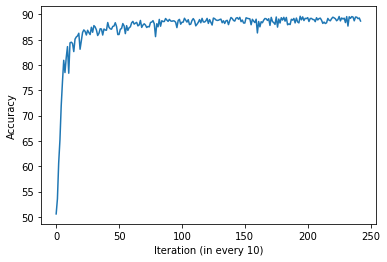

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (accuracy_gain)
plt.plot(accuracy_gain)
plt.ylabel('Accuracy')
plt.xlabel('Iteration (in every 10)')
plt.show()

### Save Model

In [ ]:
save_model = True
root_path='/content/drive/MyDrive/savedmodels/'
if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), root_path + 'sc2.pkl') 

### Load Model

In [ ]:
load_model = True
root_path='/content/drive/MyDrive/savedmodels/'
if load_model is True:
    model.load_state_dict(torch.load(root_path + 'sc2.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


### Testing Loaded Model with Digits

In [ ]:
def F_score(logit, label, threshold=0.5):
    prob = torch.sigmoid(logit)
    prob = prob > threshold
    label = label > threshold
    TP = (prob & label).sum().float()
    TN = ((~prob) & (~label)).sum().float()
    FP = (prob & (~label)).sum().float()
    FN = ((~prob) & label).sum().float()
    return TP,TN,FP,FN

In [ ]:
TP=0
TN=0
FP=0
FN=0

for images, labels in test_loader:
               
                images = images.view(-1, 48*40).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)
                
                T_P,T_N,F_P,F_N = F_score(predicted.cpu().squeeze(), labels.cpu().float())
                T_P=T_P.cpu().numpy()
                T_N=T_N.cpu().numpy()
                F_P=F_P.cpu().numpy()
                F_N=F_N.cpu().numpy()
                TP+=T_P
                TN+=T_N
                FP+=F_P
                FN+=F_N


In [ ]:
TN, TP, FN, FP, TP+TN+FP+FN

(19704.0, 15939.0, 3726.0, 1150.0, 40519.0)

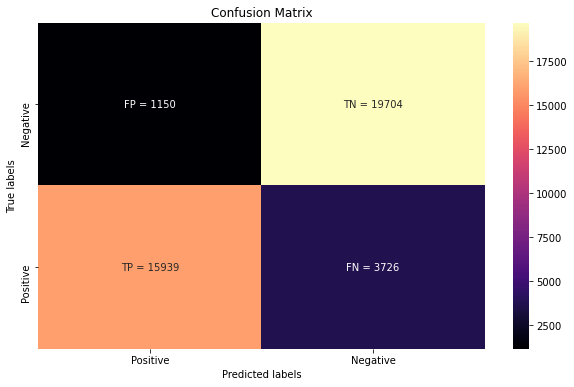

In [ ]:


import seaborn as sns
import matplotlib.pyplot as plt   
labels= [['FP = '+str(int(FP)),'TN = '+str(int(TN))],['TP = '+str(int(TP)),'FN = '+str(int(FN))]] 
values = [[FP,TN],[TP,FN]]
values=[[int(i) for i in x] for x in values]

plt.figure(figsize=(10,6))

ax= plt.subplot()

sns.heatmap(values, annot=labels, ax = ax,fmt='',cmap="magma"); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Positive','Negative']); ax.yaxis.set_ticklabels(['Negative','Positive']);

In [ ]:
accuracy = ((TP+TN)/(TP+TN+FP+FN))*100
precision = (TP / (TP + FP ))*100
recall = (TP / (TP + FN ))*100
F1 = (2 * precision * recall / ( precision + recall ))

accuracy,precision,recall,F1

(87.96613934203707, 93.27052489905788, 81.05263157894737, 86.7334167709637)

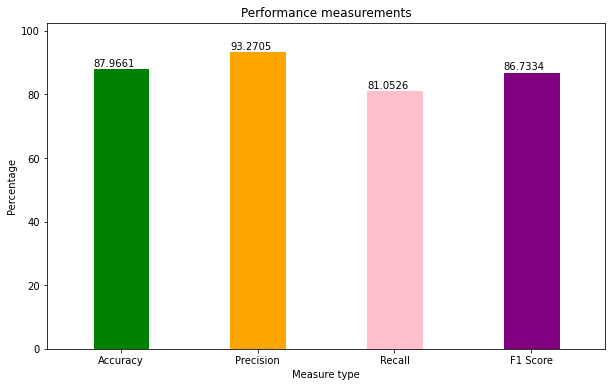

In [ ]:
data = {'Accuracy':accuracy, 'Precision':precision, 'Recall':recall,
        'F1 Score':F1}
figlabel = list(data.keys())
figvalues = list(data.values())
  
fig = plt.figure(figsize = (10, 6))
 
# creating the bar plot
barlist=plt.bar(figlabel, figvalues,width = 0.4)
barlist[0].set_color('green')
barlist[1].set_color('orange')
barlist[2].set_color('pink')
barlist[3].set_color('purple')
for bar in (barlist):
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + 1, round(yval,4))
plt.xlabel("Measure type")
plt.ylabel("Percentage")
plt.title("Performance measurements")
plt.margins(0.1)
plt.show()

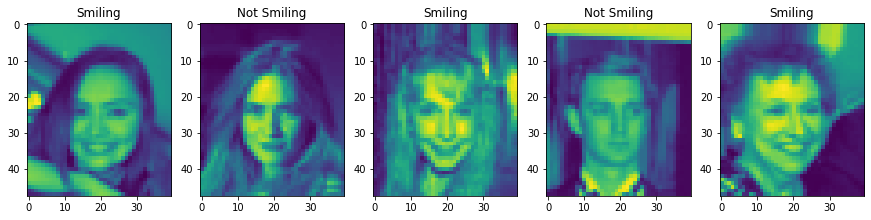

In [ ]:
for images, labels in test_loader:
    break
    
fig, ax = plt.subplots(1, 5,figsize=(15,15))
for i in range(5):
    ax[i].imshow(images[i].view(48, 40))
    if labels[i]==1:
      ax[i].set_title('Smiling')
    else:
      ax[i].set_title('Not Smiling')

plt.show()


  



In [ ]:
_, predictions = model.forward(images[:5].view(-1, 48*40).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels : ')
for i in range(5):
  if predictions[i].cpu().numpy()==1:
    print('Picture '+str(i)+' : Smiling')
  else:
    print('Picture '+str(i)+' : Not Smiling')

Predicted labels : 
Picture 0 : Smiling
Picture 1 : Not Smiling
Picture 2 : Smiling
Picture 3 : Not Smiling
Picture 4 : Smiling


# Model 3

In [ ]:
batch_size = 100
num_iters = 1216
learning_rate = 0.1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#splitting the training set to 60%, validation set to 20% and test set to 20%.

test_size = 0.2

num_train = len(train_data)

indices = list(range(num_train))

np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))       

train_idx, test_idx = indices[split:], indices[:split]  




val_size = 0.25

num2 = len(train_idx)

indices = list(range(num2))

np.random.shuffle(indices)
split = int(np.floor(val_size * num2))  
train_idx, val_idx = indices[split:], indices[:split] 




train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
val_sampler = SubsetRandomSampler(val_idx)


train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

val_loader = torch.utils.data.DataLoader(
    val_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train samples: ",len(train_sampler))
print("Test samples: ",len(test_sampler))
print("Validation samples: ",len(val_sampler))


Train samples:  121560
Test samples:  40519
Validation samples:  40520


In [ ]:

num_epochs = num_iters / (len(train_sampler) / batch_size)
num_epochs = int(num_epochs)
num_epochs

1

In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        ### 1st hidden layer: 1920 --> 500
        self.linear_1 = nn.Linear(input_size, 500)
        ### Non-linearity in 1st hidden layer
        self.layer_1 = nn.ReLU()

        ### 2nd hidden layer: 500 --> 100
        self.linear_2 = nn.Linear(500,100)
        ### Non-linearity in 2nd hidden layer
        self.layer_2 = nn.ReLU()

        



        ### Output layer: 100 --> 2
        self.linear_out = nn.Linear(100, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.layer_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.layer_2(out)

        

    
        
        # Linear layer (output)
        logits  = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = DeepNeuralNetworkModel(input_size = 48*40,
                           num_classes = 2)
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=1920, out_features=500, bias=True)
  (layer_1): ReLU()
  (linear_2): Linear(in_features=500, out_features=100, bias=True)
  (layer_2): ReLU()
  (linear_out): Linear(in_features=100, out_features=2, bias=True)
)

In [ ]:

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
accuracy_gain = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 48*40).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 10 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in val_loader:
               
                images = images.view(-1, 48*40).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            accuracy_gain.append(accuracy)
            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 10. Loss: 0.6777059435844421. Accuracy: 59.06364915224956
Iteration: 20. Loss: 0.6658448576927185. Accuracy: 64.20691527431575
Iteration: 30. Loss: 0.6343177556991577. Accuracy: 65.14721488684322
Iteration: 40. Loss: 0.5742175579071045. Accuracy: 65.08057948123103
Iteration: 50. Loss: 0.624367892742157. Accuracy: 67.29682371233248
Iteration: 60. Loss: 0.5540254712104797. Accuracy: 70.97411091093068
Iteration: 70. Loss: 0.5356115102767944. Accuracy: 70.81122436387868
Iteration: 80. Loss: 0.5030215978622437. Accuracy: 73.37051753498359
Iteration: 90. Loss: 0.8049266934394836. Accuracy: 78.51871961302105
Iteration: 100. Loss: 0.4311492443084717. Accuracy: 76.1124410770256
Iteration: 110. Loss: 0.5162013173103333. Accuracy: 73.06942422073595
Iteration: 120. Loss: 0.4810234308242798. Accuracy: 64.78935807892593
Iteration: 130. Loss: 0.39862769842147827. Accuracy: 82.02571633061034
Iteration: 140. Loss: 0.5549213886260986. Accuracy: 78.86670450899578
Iteration: 150. Loss: 0.437767

[0.6777059435844421, 0.6658448576927185, 0.6343177556991577, 0.5742175579071045, 0.624367892742157, 0.5540254712104797, 0.5356115102767944, 0.5030215978622437, 0.8049266934394836, 0.4311492443084717, 0.5162013173103333, 0.4810234308242798, 0.39862769842147827, 0.5549213886260986, 0.4377674460411072, 0.4923144578933716, 0.4706049859523773, 0.3631536066532135, 0.46907177567481995, 0.5450674295425415, 0.4737517237663269, 0.34728386998176575, 0.4092838168144226, 0.5085347890853882, 0.4547775983810425, 0.38306254148483276, 0.37792250514030457, 0.4844479262828827, 0.32419151067733765, 0.4963069260120392, 0.40175896883010864, 0.5853975415229797, 0.32639241218566895, 0.5489132404327393, 0.37490758299827576, 0.38238170742988586, 0.33531585335731506, 0.5517518520355225, 0.4317741096019745, 0.4856143891811371, 0.31178101897239685, 0.4326511323451996, 0.26714909076690674, 0.3914549946784973, 0.3661850392818451, 0.45843666791915894, 0.3967483639717102, 0.35808223485946655, 0.3911329507827759, 0.438

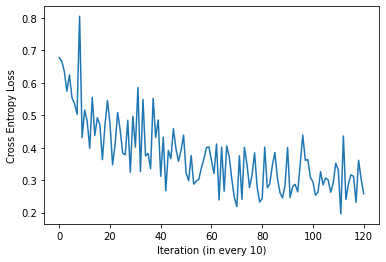

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 10)')
plt.show()

[59.06364915224956, 64.20691527431575, 65.14721488684322, 65.08057948123103, 67.29682371233248, 70.97411091093068, 70.81122436387868, 73.37051753498359, 78.51871961302105, 76.1124410770256, 73.06942422073595, 64.78935807892593, 82.02571633061034, 78.86670450899578, 81.63083985290851, 82.16145511982033, 80.84355487549051, 79.52071867518941, 80.6189688787976, 79.0518028579185, 74.99938300550359, 81.11256447592487, 81.7246230163627, 82.5464596855796, 83.1634541819887, 75.68054492953922, 84.45420666847652, 81.01631333448506, 85.72274735309361, 72.06248920259631, 83.10175473234779, 70.02147140847504, 85.41178212690343, 76.25311582220687, 86.5495199782818, 83.75330092055579, 86.4754806387127, 69.27120610084158, 84.15311335422888, 85.9325254818727, 86.1028159628816, 85.48828944445816, 86.44586490288506, 83.44233569436561, 82.80066141810015, 85.82146647251906, 82.50450405982379, 86.3594856733878, 85.86095412028925, 83.41025198055233, 82.08247982427997, 85.96460919568598, 87.46760778893852, 85.

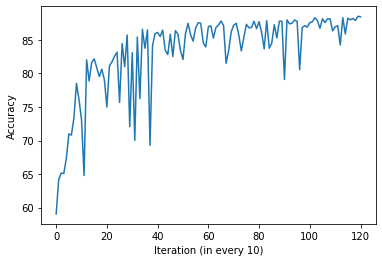

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (accuracy_gain)
plt.plot(accuracy_gain)
plt.ylabel('Accuracy')
plt.xlabel('Iteration (in every 10)')
plt.show()

### Save Model

In [ ]:
save_model = True
root_path='/content/drive/MyDrive/savedmodels/'
if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), root_path + 'sc3.pkl') 

### Load Model

In [ ]:
load_model = True
root_path='/content/drive/MyDrive/savedmodels/'
if load_model is True:
    model.load_state_dict(torch.load(root_path + 'sc3.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


### Testing Loaded Model with Digits

In [ ]:
def F_score(logit, label, threshold=0.5):
    prob = torch.sigmoid(logit)
    prob = prob > threshold
    label = label > threshold
    TP = (prob & label).sum().float()
    TN = ((~prob) & (~label)).sum().float()
    FP = (prob & (~label)).sum().float()
    FN = ((~prob) & label).sum().float()
    return TP,TN,FP,FN

In [ ]:
TP=0
TN=0
FP=0
FN=0

for images, labels in test_loader:
               
                images = images.view(-1, 48*40).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)
                
                T_P,T_N,F_P,F_N = F_score(predicted.cpu().squeeze(), labels.cpu().float())
                T_P=T_P.cpu().numpy()
                T_N=T_N.cpu().numpy()
                F_P=F_P.cpu().numpy()
                F_N=F_N.cpu().numpy()
                TP+=T_P
                TN+=T_N
                FP+=F_P
                FN+=F_N


In [ ]:
TN, TP, FN, FP, TP+TN+FP+FN

(18675.0, 17248.0, 2305.0, 2291.0, 40519.0)

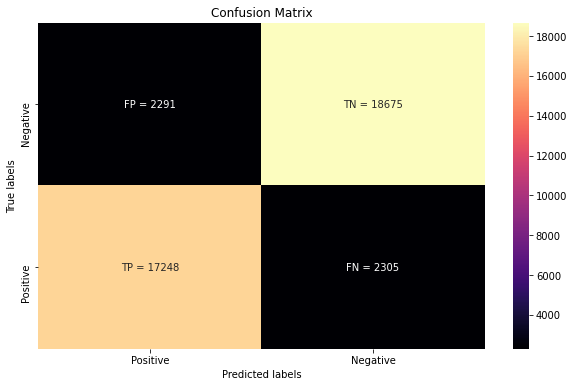

In [ ]:


import seaborn as sns
import matplotlib.pyplot as plt   
labels= [['FP = '+str(int(FP)),'TN = '+str(int(TN))],['TP = '+str(int(TP)),'FN = '+str(int(FN))]] 
values = [[FP,TN],[TP,FN]]
values=[[int(i) for i in x] for x in values]

plt.figure(figsize=(10,6))

ax= plt.subplot()

sns.heatmap(values, annot=labels, ax = ax,fmt='',cmap="magma"); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Positive','Negative']); ax.yaxis.set_ticklabels(['Negative','Positive']);

In [ ]:
accuracy = ((TP+TN)/(TP+TN+FP+FN))*100
precision = (TP / (TP + FP ))*100
recall = (TP / (TP + FN ))*100
F1 = (2 * precision * recall / ( precision + recall ))

accuracy,precision,recall,F1

(88.65717317801524, 88.27473258610982, 88.21152764281696, 88.24311879668475)

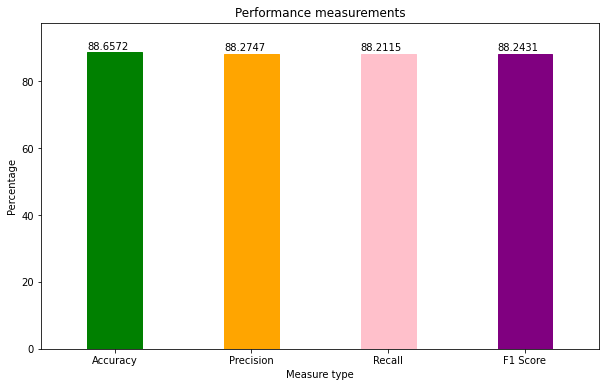

In [ ]:
data = {'Accuracy':accuracy, 'Precision':precision, 'Recall':recall,
        'F1 Score':F1}
figlabel = list(data.keys())
figvalues = list(data.values())
  
fig = plt.figure(figsize = (10, 6))
 
# creating the bar plot
barlist=plt.bar(figlabel, figvalues,width = 0.4)
barlist[0].set_color('green')
barlist[1].set_color('orange')
barlist[2].set_color('pink')
barlist[3].set_color('purple')
for bar in (barlist):
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + 1, round(yval,4))
plt.xlabel("Measure type")
plt.ylabel("Percentage")
plt.title("Performance measurements")
plt.margins(0.1)
plt.show()

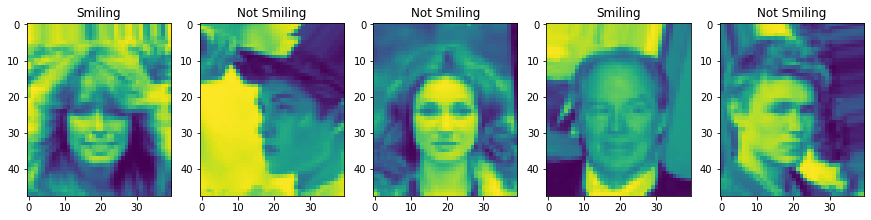

In [ ]:
for images, labels in test_loader:
    break
    
fig, ax = plt.subplots(1, 5,figsize=(15,15))
for i in range(5):
    ax[i].imshow(images[i].view(48, 40))
    if labels[i]==1:
      ax[i].set_title('Smiling')
    else:
      ax[i].set_title('Not Smiling')

plt.show()


  



In [ ]:
_, predictions = model.forward(images[:5].view(-1, 48*40).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels : ')
for i in range(5):
  if predictions[i].cpu().numpy()==1:
    print('Picture '+str(i)+' : Smiling')
  else:
    print('Picture '+str(i)+' : Not Smiling')

Predicted labels : 
Picture 0 : Smiling
Picture 1 : Not Smiling
Picture 2 : Not Smiling
Picture 3 : Smiling
Picture 4 : Not Smiling


# Model 4

In [ ]:
batch_size = 100
num_iters = 2432
learning_rate = 0.001
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#splitting the training set to 60%, validation set to 20% and test set to 20%.

test_size = 0.2

num_train = len(train_data)

indices = list(range(num_train))

np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))        

train_idx, test_idx = indices[split:], indices[:split]  




val_size = 0.25

num2 = len(train_idx)

indices = list(range(num2))

np.random.shuffle(indices)
split = int(np.floor(val_size * num2))  
train_idx, val_idx = indices[split:], indices[:split] 




train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
val_sampler = SubsetRandomSampler(val_idx)


train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

val_loader = torch.utils.data.DataLoader(
    val_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train samples: ",len(train_sampler))
print("Test samples: ",len(test_sampler))
print("Validation samples: ",len(val_sampler))


Train samples:  121560
Test samples:  40519
Validation samples:  40520


In [ ]:

num_epochs = num_iters / (len(train_sampler) / batch_size)
num_epochs = int(num_epochs)
num_epochs

2

In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        ### 1st hidden layer: 1920 --> 500
        self.linear_1 = nn.Linear(input_size, 500)
        ### Non-linearity in 1st hidden layer
        self.layer_1 = nn.ReLU()

        ### 2nd hidden layer: 500 --> 100
        self.linear_2 = nn.Linear(500,100)
        ### Non-linearity in 2nd hidden layer
        self.layer_2 = nn.LeakyReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(100,100)
        ### Non-linearity in 3rd hidden layer
        self.layer_3 = nn.LeakyReLU()



        ### Output layer: 100 --> 2
        self.linear_out = nn.Linear(100, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.layer_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.layer_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.layer_3(out)

        

    
        
        # Linear layer (output)
        logits  = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = DeepNeuralNetworkModel(input_size = 48*40,
                           num_classes = 2)
model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=1920, out_features=500, bias=True)
  (layer_1): ReLU()
  (linear_2): Linear(in_features=500, out_features=100, bias=True)
  (layer_2): LeakyReLU(negative_slope=0.01)
  (linear_3): Linear(in_features=100, out_features=100, bias=True)
  (layer_3): LeakyReLU(negative_slope=0.01)
  (linear_out): Linear(in_features=100, out_features=2, bias=True)
)

In [ ]:

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
accuracy_gain = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 48*40).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 10 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in val_loader:
               
                images = images.view(-1, 48*40).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            accuracy_gain.append(accuracy)
            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 10. Loss: 0.6081503033638. Accuracy: 60.19891902564229
Iteration: 20. Loss: 0.6099258661270142. Accuracy: 68.3086946864434
Iteration: 30. Loss: 0.5692328810691833. Accuracy: 75.80887978479232
Iteration: 40. Loss: 0.4439619183540344. Accuracy: 79.24677311878378
Iteration: 50. Loss: 0.4929637908935547. Accuracy: 79.00244329820578
Iteration: 60. Loss: 0.5150737762451172. Accuracy: 82.5859473333498
Iteration: 70. Loss: 0.485038161277771. Accuracy: 81.10516054196796
Iteration: 80. Loss: 0.4121321439743042. Accuracy: 81.49756904168414
Iteration: 90. Loss: 0.45763081312179565. Accuracy: 84.75529998272415
Iteration: 100. Loss: 0.4322579503059387. Accuracy: 81.51731286556924
Iteration: 110. Loss: 0.30265069007873535. Accuracy: 84.10375379451615
Iteration: 120. Loss: 0.2606523036956787. Accuracy: 83.43739973839433
Iteration: 130. Loss: 0.5110633373260498. Accuracy: 84.68866457711198
Iteration: 140. Loss: 0.36033177375793457. Accuracy: 84.88363483797724
Iteration: 150. Loss: 0.34752410

[0.6081503033638, 0.6099258661270142, 0.5692328810691833, 0.4439619183540344, 0.4929637908935547, 0.5150737762451172, 0.485038161277771, 0.4121321439743042, 0.45763081312179565, 0.4322579503059387, 0.30265069007873535, 0.2606523036956787, 0.5110633373260498, 0.36033177375793457, 0.34752410650253296, 0.4052751660346985, 0.20186921954154968, 0.3504545986652374, 0.2480844110250473, 0.4040745496749878, 0.33115535974502563, 0.22780916094779968, 0.264881432056427, 0.2793557047843933, 0.3158000111579895, 0.35483306646347046, 0.2573929727077484, 0.3354041576385498, 0.20746314525604248, 0.2509065866470337, 0.23553894460201263, 0.38008469343185425, 0.2947288155555725, 0.3106306195259094, 0.31373414397239685, 0.3940509557723999, 0.3618314862251282, 0.262645959854126, 0.3435728847980499, 0.22414740920066833, 0.3158477544784546, 0.31744638085365295, 0.3244750201702118, 0.28338295221328735, 0.3160730004310608, 0.2821826636791229, 0.18046019971370697, 0.21611133217811584, 0.2741820216178894, 0.290042

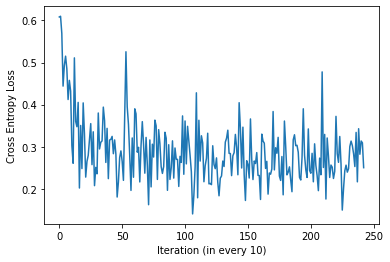

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 10)')
plt.show()

[60.19891902564229, 68.3086946864434, 75.80887978479232, 79.24677311878378, 79.00244329820578, 82.5859473333498, 81.10516054196796, 81.49756904168414, 84.75529998272415, 81.51731286556924, 84.10375379451615, 83.43739973839433, 84.68866457711198, 84.88363483797724, 86.58160369209507, 86.94192847799798, 86.71240652533379, 86.82346553468743, 86.40637725511489, 85.18226017423925, 87.03077568548089, 86.3866334312298, 84.7651718946667, 85.98435301957106, 87.02583972950961, 85.19213208618179, 86.78150990893161, 86.84567733655815, 87.21340605641798, 87.49722352476616, 87.50956341469434, 84.96507811150325, 87.54164712850762, 88.1857893827587, 87.90197191441052, 88.26229670031343, 86.73955428317579, 84.99222586934525, 87.59347466620598, 88.10187813124706, 88.30918828204052, 88.13149386707471, 88.01796687973544, 88.02043485772107, 87.95133147412325, 86.95673634591179, 87.58607073224907, 87.72427749944471, 87.90937584836743, 87.8328685308127, 87.71193760951653, 87.54905106246453, 86.7469582171327,

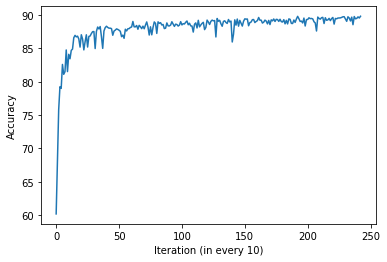

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (accuracy_gain)
plt.plot(accuracy_gain)
plt.ylabel('Accuracy')
plt.xlabel('Iteration (in every 10)')
plt.show()

### Save Model

In [ ]:
save_model = True
root_path='/content/drive/MyDrive/savedmodels/'
if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), root_path + 'sc4.pkl') 

### Load Model

In [ ]:
load_model = True
root_path='/content/drive/MyDrive/savedmodels/'
if load_model is True:
    model.load_state_dict(torch.load(root_path + 'sc4.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


### Testing Loaded Model with Digits

In [ ]:
def F_score(logit, label, threshold=0.5):
    prob = torch.sigmoid(logit)
    prob = prob > threshold
    label = label > threshold
    TP = (prob & label).sum().float()
    TN = ((~prob) & (~label)).sum().float()
    FP = (prob & (~label)).sum().float()
    FN = ((~prob) & label).sum().float()
    return TP,TN,FP,FN

In [ ]:
TP=0
TN=0
FP=0
FN=0

for images, labels in test_loader:
               
                images = images.view(-1, 48*40).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)
                
                T_P,T_N,F_P,F_N = F_score(predicted.cpu().squeeze(), labels.cpu().float())
                T_P=T_P.cpu().numpy()
                T_N=T_N.cpu().numpy()
                F_P=F_P.cpu().numpy()
                F_N=F_N.cpu().numpy()
                TP+=T_P
                TN+=T_N
                FP+=F_P
                FN+=F_N


In [ ]:
TN, TP, FN, FP, TP+TN+FP+FN

(19554.0, 16751.0, 2688.0, 1526.0, 40519.0)

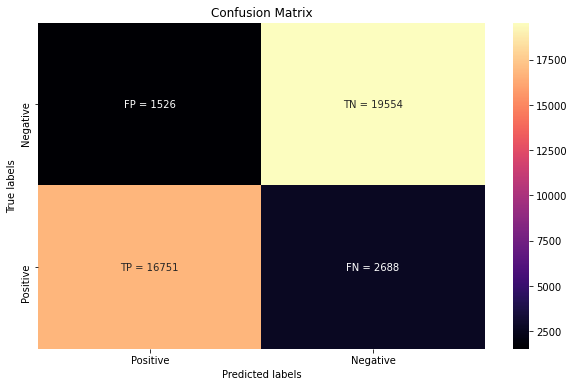

In [ ]:


import seaborn as sns
import matplotlib.pyplot as plt   
labels= [['FP = '+str(int(FP)),'TN = '+str(int(TN))],['TP = '+str(int(TP)),'FN = '+str(int(FN))]] 
values = [[FP,TN],[TP,FN]]
values=[[int(i) for i in x] for x in values]

plt.figure(figsize=(10,6))

ax= plt.subplot()

sns.heatmap(values, annot=labels, ax = ax,fmt='',cmap="magma"); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Positive','Negative']); ax.yaxis.set_ticklabels(['Negative','Positive']);

In [ ]:
accuracy = ((TP+TN)/(TP+TN+FP+FN))*100
precision = (TP / (TP + FP ))*100
recall = (TP / (TP + FN ))*100
F1 = (2 * precision * recall / ( precision + recall ))

accuracy,precision,recall,F1

(89.59994076852834, 91.65070854078897, 86.17212819589484, 88.82702301410541)

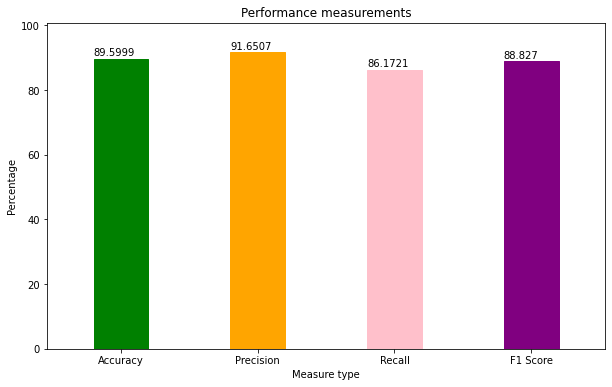

In [ ]:
data = {'Accuracy':accuracy, 'Precision':precision, 'Recall':recall,
        'F1 Score':F1}
figlabel = list(data.keys())
figvalues = list(data.values())
  
fig = plt.figure(figsize = (10, 6))
 
# creating the bar plot
barlist=plt.bar(figlabel, figvalues,width = 0.4)
barlist[0].set_color('green')
barlist[1].set_color('orange')
barlist[2].set_color('pink')
barlist[3].set_color('purple')
for bar in (barlist):
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + 1, round(yval,4))
plt.xlabel("Measure type")
plt.ylabel("Percentage")
plt.title("Performance measurements")
plt.margins(0.1)
plt.show()

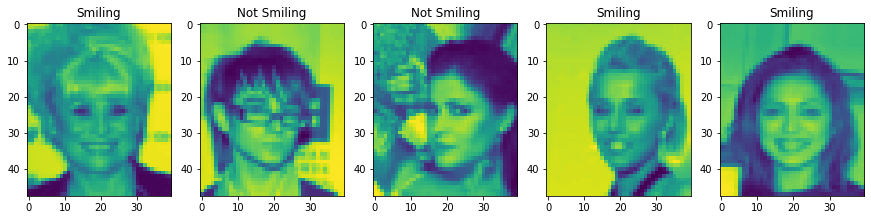

In [ ]:
for images, labels in test_loader:
    break
    
fig, ax = plt.subplots(1, 5,figsize=(15,15))
for i in range(5):
    ax[i].imshow(images[i].view(48, 40))
    if labels[i]==1:
      ax[i].set_title('Smiling')
    else:
      ax[i].set_title('Not Smiling')

plt.show()


  



In [ ]:
_, predictions = model.forward(images[:5].view(-1, 48*40).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels : ')
for i in range(5):
  if predictions[i].cpu().numpy()==1:
    print('Picture '+str(i)+' : Smiling')
  else:
    print('Picture '+str(i)+' : Not Smiling')

Predicted labels : 
Picture 0 : Smiling
Picture 1 : Not Smiling
Picture 2 : Not Smiling
Picture 3 : Smiling
Picture 4 : Smiling
